In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
date_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
# Загрузка датасетов
data_dir = "data/jellyfish/Train_Test_Valid/"
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), date_transforms[x])
    for x in ["train", "val"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=4, 
        shuffle=True,
        num_workers=4,)
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes
print(class_names)

['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.255])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

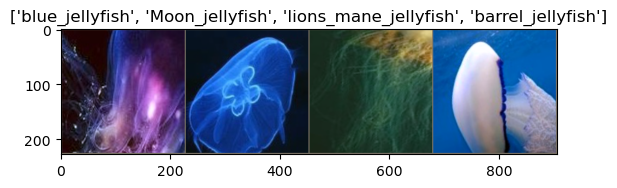

In [6]:
inputs, classes = next(iter(dataloaders["train"]))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:4f}")

    model.load_state_dict(best_model_wts)
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features    # model_ft.fc -- это слой Linear
model_ft.fc = nn.Linear(num_ftrs, 6)  # подменяем оригинальный слой своим

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Уменьшаем скорость обучения с коэффициентом 0.1 каждые 7 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/home/user/miniconda3/envs/torch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/user/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


train Loss: 1.3334 Acc: 0.4911
val Loss: 1.0736 Acc: 0.6154

Epoch 1/24
----------
train Loss: 1.0539 Acc: 0.6289
val Loss: 1.0754 Acc: 0.6923

Epoch 2/24
----------
train Loss: 0.9507 Acc: 0.6889
val Loss: 1.5391 Acc: 0.5641

Epoch 3/24
----------
train Loss: 0.9496 Acc: 0.6789
val Loss: 1.5569 Acc: 0.6923

Epoch 4/24
----------
train Loss: 0.8646 Acc: 0.7100
val Loss: 1.7391 Acc: 0.6154

Epoch 5/24
----------
train Loss: 0.7223 Acc: 0.7489
val Loss: 1.0998 Acc: 0.7179

Epoch 6/24
----------
train Loss: 0.5804 Acc: 0.8089
val Loss: 0.9322 Acc: 0.7436

Epoch 7/24
----------
train Loss: 0.4705 Acc: 0.8322
val Loss: 0.9868 Acc: 0.7949

Epoch 8/24
----------
train Loss: 0.4061 Acc: 0.8522
val Loss: 1.0081 Acc: 0.7692

Epoch 9/24
----------
train Loss: 0.4091 Acc: 0.8678
val Loss: 0.9273 Acc: 0.7692

Epoch 10/24
----------
train Loss: 0.4270 Acc: 0.8678
val Loss: 1.0607 Acc: 0.8462

Epoch 11/24
----------
train Loss: 0.3416 Acc: 0.8833
val Loss: 1.0921 Acc: 0.8205

Epoch 12/24
----------
t

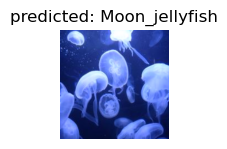

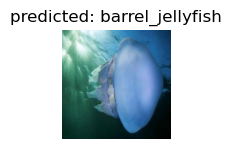

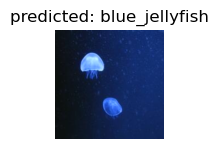

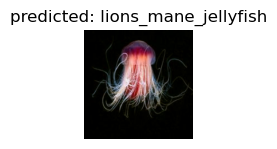

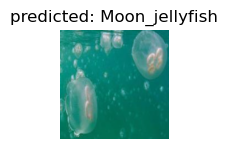

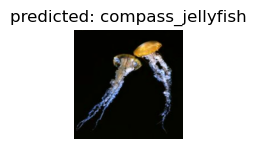

In [11]:
visualize_model(model_ft)

In [13]:
# заморозить веса оригинальной модели
model_conv = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features    # model_ft.fc -- это слой Linear
model_conv.fc = nn.Linear(num_ftrs, 6)  # подменяем оригинальный слой своим

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Уменьшаем скорость обучения с коэффициентом 0.1 каждые 7 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3516 Acc: 0.8733
val Loss: 1.0279 Acc: 0.7692

Epoch 1/24
----------
train Loss: 0.3892 Acc: 0.8767
val Loss: 0.9623 Acc: 0.7949

Epoch 2/24
----------
train Loss: 0.3482 Acc: 0.8811
val Loss: 1.0884 Acc: 0.7949

Epoch 3/24
----------
train Loss: 0.3944 Acc: 0.8667
val Loss: 0.9915 Acc: 0.8462

Epoch 4/24
----------
train Loss: 0.4262 Acc: 0.8567
val Loss: 0.9603 Acc: 0.7692

Epoch 5/24
----------
train Loss: 0.4049 Acc: 0.8656
val Loss: 0.9906 Acc: 0.8462

Epoch 6/24
----------
train Loss: 0.4160 Acc: 0.8700
val Loss: 1.0179 Acc: 0.7949

Epoch 7/24
----------
train Loss: 0.3923 Acc: 0.8722
val Loss: 1.0375 Acc: 0.7949

Epoch 8/24
----------
train Loss: 0.3920 Acc: 0.8700
val Loss: 0.9444 Acc: 0.8205

Epoch 9/24
----------
train Loss: 0.3293 Acc: 0.8789
val Loss: 1.0910 Acc: 0.8205

Epoch 10/24
----------
train Loss: 0.3793 Acc: 0.8644
val Loss: 1.0198 Acc: 0.7949

Epoch 11/24
----------
train Loss: 0.3674 Acc: 0.8778
val Loss: 0.9397 Acc: 0.8462

Ep

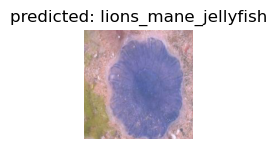

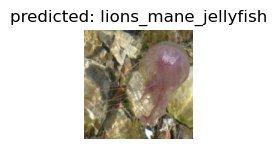

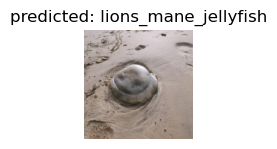

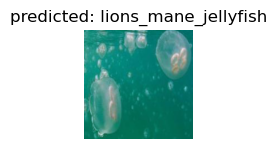

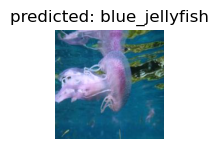

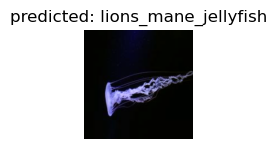

In [15]:
visualize_model(model_conv)